<a href="https://colab.research.google.com/github/inequihi/Redes-Neuronales/blob/main/TP1_Redes_Neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hacer un clasificador de texto con la base de datos The 20 News Groups

Para el dataset armar un modelo multiomial Naive Bayes donde se pide:

- EDA
- Metrica
- Busqueda de hiperparametros
- Paralelizacion
- Evaluacion


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk

## Separo data set en TRAIN, VALIDATION y TEST

In [ ]:
from sklearn.datasets import load_files
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

twenty_train_ALL = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'))

# 20% va a validation
train_data, val_data, train_labels, val_labels = train_test_split(twenty_train_ALL.data, twenty_train_ALL.target, test_size=0.2, random_state=42)

twenty_train = {
    'data': train_data,
    'target': train_labels,
    'filenames': None,  # You can set filenames if available
    'DESCR': None,      # You can provide a description
    'target_names': twenty_train_ALL.target_names
}

twenty_validation = {
    'data': val_data,
    'target': val_labels,
    'filenames': None,  # You can set filenames if available
    'DESCR': None,      # You can provide a description
    'target_names': twenty_train_ALL.target_names
}
twenty_test = fetch_20newsgroups(subset='test', remove=('headers','footers','quotes'))


## EDA

In [ ]:
cantArticulosTrain = len(twenty_train["data"]) #Cantidad de artículos periodísticos
cantClasificacionesTrain = len(twenty_train["target"]) #Cantidad de clasificaciones. Debería coincidir con la cantidad de artículos
cantCategoriasTrain = len(twenty_train["target_names"]) #Cantidad de categorías

print("TRAIN\nCantidad de articulos:", cantArticulosTrain )
print("Cantidad de categorias:",cantCategoriasTrain)

# Estudiamos las diferentes categorias
categorias = twenty_train["target_names"] #Referencia de las clasificaciones.
# Create a DataFrame from the list
categories_df = pd.DataFrame(categorias, columns=["Categorias"], index=range(1, len(categorias)+1))
# Vemos cuantos
print("En total hay ",twenty_train["target"], "categorias de articulos") #Clasificaciones de los artículos

# Printing the DataFrame
categories_df

TRAIN
Cantidad de articulos: 9051
Cantidad de categorias: 20
En total hay  [ 6 15 15 ...  0 17 10] categorias de articulos


,Categorias
1,alt.atheism
2,comp.graphics
3,comp.os.ms-windows.misc
4,comp.sys.ibm.pc.hardware
5,comp.sys.mac.hardware
6,comp.windows.x
7,misc.forsale
8,rec.autos
9,rec.motorcycles
10,rec.sport.baseball


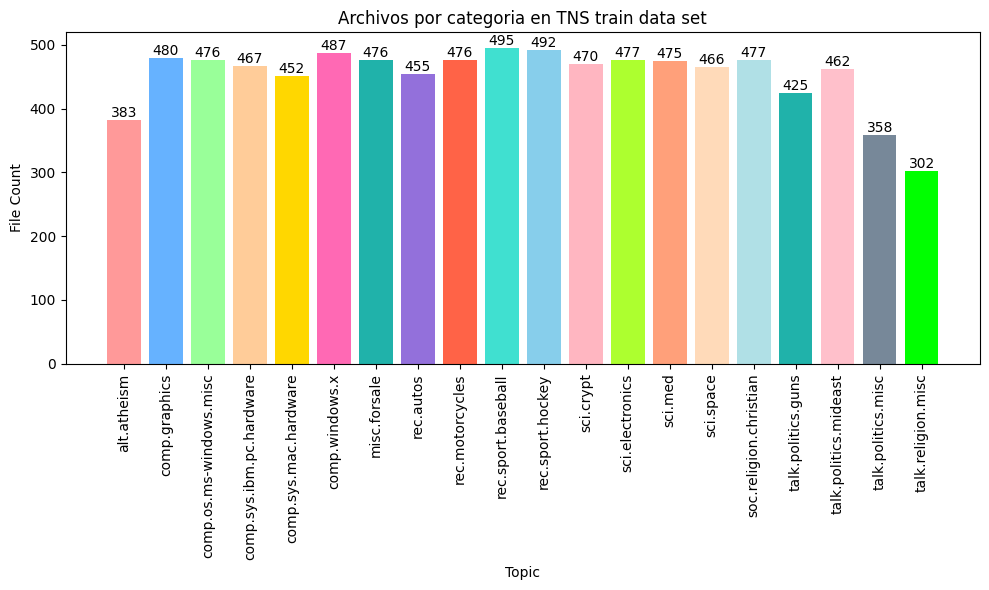

In [ ]:
# Articulos por tema en el TRAIN set
import pandas as pd
import matplotlib.pyplot as plt

data = {'Topic': twenty_train["target_names"], 'File Count': [0] * len(twenty_train["target_names"])}
df_data = pd.DataFrame(data)

# Contar los archivos por tema
for target in twenty_train["target"]:
    df_data.loc[target, 'File Count'] += 1

# Generate pastel colors
pastel_colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FFD700', '#FF69B4', '#20B2AA', '#9370DB', '#FF6347', '#40E0D0',
                 '#87CEEB', '#FFB6C1', '#ADFF2F', '#FFA07A', '#FFDAB9', '#B0E0E6', '#20B2AA', '#FFC0CB', '#778899', '#00FF00']

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(df_data['Topic'], df_data['File Count'], color=pastel_colors)
plt.xticks(rotation=90)
plt.xlabel('Topic')
plt.ylabel('File Count')
plt.title('Archivos por categoria en TNS train data set')

# Add count numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

In [ ]:
# Vemos otro articulo por ejemplo el n16
articulo = 15
print("------------------------------------------------------------------------------------")
print("Articulo Nº",articulo)
clasificacion =  twenty_train["target"][articulo]
print("Clasificacion: Nº" ,clasificacion)  #Código de clasificación del artículo

print(twenty_train["target_names"][clasificacion]) #Clasificación del artículo
print("------------------------------------------------------------------------------------")
print(twenty_train["data"][articulo])     # Cuerpo artículo

------------------------------------------------------------------------------------
Articulo Nº 15
Clasificacion: Nº 11
sci.crypt
------------------------------------------------------------------------------------

   Each chip includes the following components:

      the Skipjack encryption algorithm
      F, an 80-bit family key that is common to all chips
      N, a 30-bit serial number
      U, an 80-bit secret key that unlocks all messages encrypted with the chip

Hmmm. A thirty bit serial number. And, we are told, the unit key U is
derived deterministically from this serial number. That means that
there are only one billion possible unit keys.

   To generate the unit key for a serial number N, the 30-bit value N is
   first padded with a fixed 34-bit block to produce a 64-bit block N1.
   S1 and S2 are then used as keys to triple-encrypt N1, producing a
   64-bit block R1:

	   R1 = E[D[E[N1; S1]; S2]; S1] .

   Similarly, N is padded with two other 34-bit blocks to produce N

### Normalizacion de los Articulos


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Tokenizamos el articulo  [en tokens de 1 palabra]
art=twenty_train["data"][0]
tok=word_tokenize(art)
print("\nArtículo tokenizado:")
print(tok)

# Step 1: LEMATIZACION
# Lematiza cada token en el texto.
# La lematización reduce las palabras a su forma base o de diccionario, lo cual
# puede ser útil para normalizar el texto. El parámetro pos='v' especifica que
# la lematización debe realizarse con respecto a los verbos.

lem=[lemmatizer.lemmatize(x,pos='v') for x in tok]
print("\nLematización")
print(lem)

# Step 2: Eliminacion de STOP words (en ingles)
# Eliminamos palabras que no aportan conocimiento en el estudio de la clase del
# texto ya que se repiten generlamente en todos los articulos y no aportan
# significado
stop = [x for x in lem if x not in stopwords.words('english')]
print("\nEliminando stopwords:")
print(stop)

# Step 3: STEMMING
# Se aplica stemming a cada token después de la eliminación de stopwords.
# El stemming reduce las palabras a su forma raíz, lo cual puede implicar la
# eliminación de prefijos o sufijos. Este paso ayuda a normalizar aún más el texto.
stem=[stemmer.stem(x) for x in stop]
print("\nAplicando stemming")
print(stem)

# Step 4: Filtrado alfabetico
# Se filtran los tokens no alfabéticos de los tokens stemizados.
# Este paso garantiza que solo se conserven palabras alfabéticas en la lista final,
# eliminando cualquier signo de puntuación o caracteres que no sean palabras.
alpha=[x for x in stem if x.isalpha()]
print("\nFiltrando no-palabras:")
print(alpha)

# Ejemplo de primer articulo
# Vemos el articulo post filtrado
articulo = 0
print("------------------------------------------------------------------------------------")
print("Articulo Nº",articulo)
clasificacion =  twenty_train["target"][articulo]
print("Clasificacion: Nº" ,clasificacion)  #Código de clasificación del artículo
print(twenty_train["target_names"][clasificacion]) #Clasificación del artículo

print("-----------------------------  BEFORE  --------------------------------------")
print(twenty_train["data"][0])     # Cuerpo artículo
print("\n")
print("-----------------------------  AFTER  ----------------------------------------")
print(alpha)


from tqdm import tqdm

##### TRAIN DATA  ######
# Aplicamos TOKENIZACION + LEMMATIZER + ELIMINACION DE STOPWORDS + ALPHA  a todos los articulos
articulos_filtrados_train = list()

for idx in tqdm(range(len(twenty_train["data"]))):
    art=twenty_train["data"][idx]
    tok=word_tokenize(art)
    lem=[lemmatizer.lemmatize(x,pos='v') for x in tok]
    stop = [x for x in lem if x not in stopwords.words('english')]
    stem=[stemmer.stem(x) for x in stop]
    alpha=[x for x in stem if x.isalpha()]
    articulos_filtrados_train.append(" ".join(alpha))

#####  VALIDATION DATA  #####
# Aplicamos TOKENIZACION + LEMMATIZER + ELIMINACION DE STOPWORDS + ALPHA  a todos los articulos
articulos_filtrados_validation = list()
for idx in tqdm(range(len(twenty_validation["data"]))):
    art=twenty_validation["data"][idx]
    tok=word_tokenize(art)
    lem=[lemmatizer.lemmatize(x,pos='v') for x in tok]
    stop = [x for x in lem if x not in stopwords.words('english')]
    stem=[stemmer.stem(x) for x in stop]
    alpha=[x for x in stem if x.isalpha()]
    articulos_filtrados_validation.append(" ".join(alpha))

#####  TEST DATA  #####
# Aplicamos TOKENIZACION + LEMMATIZER + ELIMINACION DE STOPWORDS + ALPHA  a todos los articulos
articulos_filtrados_test = list()
for idx in tqdm(range(len(twenty_test["data"]))):
    art=twenty_test["data"][idx]
    tok=word_tokenize(art)
    lem=[lemmatizer.lemmatize(x,pos='v') for x in tok]
    stop = [x for x in lem if x not in stopwords.words('english')]
    stem=[stemmer.stem(x) for x in stop]
    alpha=[x for x in stem if x.isalpha()]
    articulos_filtrados_test.append(" ".join(alpha))

#Salvado del procesamiento a disco:
import pickle

with open('art_filt.txt', 'wb') as fp:
    pickle.dump(articulos_filtrados_train, fp)

with open ('art_filt.txt', 'rb') as fp:
    itemlist = pickle.load(fp)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Artículo tokenizado:
['Nikon', 'FM-2n', 'with', '50', 'mm', 'Nikkor', 'and', 'accessories', 'for', 'sale.I', 'bought', 'this', 'camera', 'in', 'Hong', 'Kong', 'two', 'years', 'ago', 'and', 'everything', 'has', 'been', 'looked', 'after', 'very', 'well', '.', 'I', "'m", 'now', 'selling', 'some', 'more', 'gear', 'to', 'finance', 'my', 'next', 'big', 'film', 'project', '.']

Lematización
['Nikon', 'FM-2n', 'with', '50', 'mm', 'Nikkor', 'and', 'accessories', 'for', 'sale.I', 'buy', 'this', 'camera', 'in', 'Hong', 'Kong', 'two', 'years', 'ago', 'and', 'everything', 'have', 'be', 'look', 'after', 'very', 'well', '.', 'I', "'m", 'now', 'sell', 'some', 'more', 'gear', 'to', 'finance', 'my', 'next', 'big', 'film', 'project', '.']

Eliminando stopwords:
['Nikon', 'FM-2n', '50', 'mm', 'Nikkor', 'accessories', 'sale.I', 'buy', 'camera', 'Hong', 'Kong', 'two', 'years', 'ago', 'everything', 'look', 'well', '.', 'I', "'m", 'sell', 'gear', 'finance', 'next', 'big', 'film', 'project', '.']

Aplicando s

100%|██████████| 7532/7532 [04:43<00:00, 26.59it/s]


### Count de palabras en los articulos

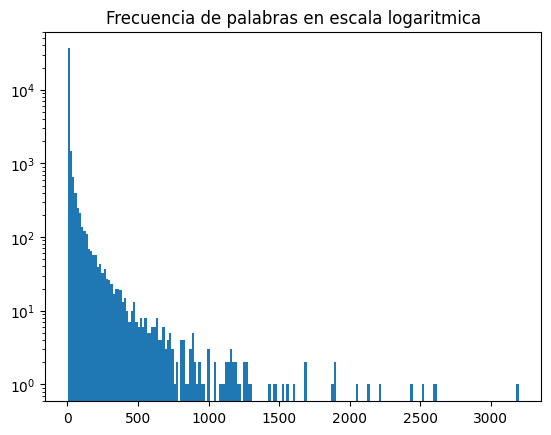

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()

# Crear una matriz de términos-documentos --> Fit input samples
train_data_Vocab = count_vect.fit_transform(articulos_filtrados_train)

# Obtener los unigrams --> Frecuencia de palabras en todos los documentos en train
doc_freq = np.array(train_data_Vocab.astype(bool).sum(axis=0)).flatten()

a = plt.hist(doc_freq, bins=200,log=True)
plt.title('Frecuencia de palabras en escala logaritmica')
plt.show()


In [ ]:
data = count_vect.vocabulary_
print(len(data))

df_Palabras = pd.DataFrame(list(data.items()), columns=['Word', 'Freq'])
df_Palabras.head(15)

40374


,Word,Freq
0,nikon,23721
1,mm,22039
2,nikkor,23713
3,accessori,174
4,buy,4588
5,camera,4801
6,hong,15145
7,kong,18553
8,two,35672
9,year,39693


In [ ]:
### Veamos la plabra con max ocurrencia en el articulo 14
articulo = 0
maxOcurr = train_data_Vocab.toarray()[articulo].argmax() #Veamos a qué palabra pertenece la máxima ocurrencia en el primer artíclo

# Obtener el vocabulario del vectorizador de texto
vocabulario = count_vect.get_feature_names_out()

# Obtener la palabra con la ocurrencia máxima en el primer artículo
palabra_max_ocurrencia = vocabulario[maxOcurr]

print("Palabra con maxima ocurrencia del articulo Nº" , articulo , "es", palabra_max_ocurrencia, "unas:" , maxOcurr, "en todos los documentos")

Palabra con maxima ocurrencia del articulo Nº 0 es accessori unas: 174 en todos los documentos


# Multinomial Naive Bayes con CV

## Train

### Busqueda de Hiperparametros: max_df, min_df y alpha

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

#### Count Vectorizer  ---> Max df y Min df
#max_df: Límite en la frecuencia máxima de documento de las palabras.
#        Se eliminan las palabras que aparezcan en más del max_df% de los documentos.
#min_df: Límite en la frecuencia mínima de documento de las palabras.
#        Se eliminan las palabras que aparezcan en menos del min_df% de los documentos.

#### MultinomialNB   ---> alpha
# alpha: suavizado de la sprobabilidades
CountVctr = CountVectorizer()
MNBmodel = MultinomialNB()

param_grid = {
                #'vectorizer__max_df' : [0.15],
                'vectorizer__max_df' : np.linspace(0.035, 0.050, num=5),
                'vectorizer__min_df' : [1],
                #'classifier__alpha': [ 0.005 , 0.000015]
                'classifier__alpha' : np.linspace(0.010, 0.15, num=5)
              }

pipeline = Pipeline([
    ('vectorizer', CountVctr),
    ('classifier', MNBmodel)
])

gridSearch = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=10, refit = True)
gridSearch.fit(articulos_filtrados_train, twenty_train["target"])  # Fit the training data


Fitting 3 folds for each of 25 candidates, totalling 75 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'classifier__alpha': array([0.01 , 0.045, 0.08 , 0.115, 0.15 ]),
                         'vectorizer__max_df': array([0.035  , 0.03875, 0.0425 , 0.04625, 0.05   ]),
                         'vectorizer__min_df': [1]},
             scoring='accuracy', verbose=10)

El mejor resultado fue: 0.691415313225058
Best parameters:
Best min df: 1
Best max df: 0.0425
Best alpha: 0.11499999999999998


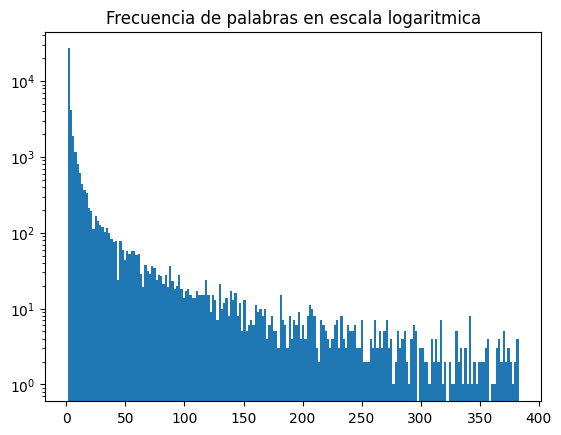

MultinomialNB(alpha=0.11499999999999998)

In [ ]:
print('El mejor resultado fue: {}'.format(gridSearch.best_score_))
print('Best parameters:')
best_parameters = gridSearch.best_estimator_.get_params()

best_min_df = best_parameters['vectorizer__min_df']
best_max_df = best_parameters['vectorizer__max_df']

print("Best min df:", best_min_df)
print("Best max df:", best_max_df)

#best_min_df = 2
#best_max_df = 0.15

best_alpha = gridSearch.best_params_['classifier__alpha']
print("Best alpha:", best_alpha)

###### OBTENGO EL MEJOR MODELO RESULTADO DEL GRID SEARCH #####
#### Crear una matriz de términos-documentos --> Fit input samples
# Con max_df y min_df obtenidos antes
best_count_vectorizer = CountVectorizer(min_df=best_min_df, max_df=best_max_df)
train_data_Vocab = best_count_vectorizer.fit_transform(articulos_filtrados_train)

# Obtener los unigrams --> Frecuencia de palabras en todos los documentos en train
doc_freq = np.array(train_data_Vocab.astype(bool).sum(axis=0)).flatten()

a = plt.hist(doc_freq, bins=200,log=True)
plt.title('Frecuencia de palabras en escala logaritmica')
plt.show()

##### ENTRENO #####
best_model_pipeline = MultinomialNB(alpha = best_alpha)
best_model_pipeline.fit(train_data_Vocab.toarray(), twenty_train["target"])
####################


In [ ]:
porc=sum(np.array(best_model_pipeline.predict(train_data_Vocab.toarray()))==np.array(twenty_train["target"]))/cantArticulosTrain*100
print("TRAIN\nEl porcentaje de artículos clasificados correctamente es: {}%".format(porc))


TRAIN
El porcentaje de artículos clasificados correctamente es: 88.27753839354767%


### Validation

In [ ]:
cantArticulosValidation = len(twenty_validation["data"]) #Cantidad de artículos periodísticos
print("VALIDATION\nCantidad de articulos:", cantArticulosValidation )
validation_data_Vocab = best_count_vectorizer.transform(articulos_filtrados_validation)

porc=sum(np.array(best_model_pipeline.predict(validation_data_Vocab.toarray()))==np.array(twenty_validation["target"]))/cantArticulosValidation*100
print("El porcentaje de artículos clasificados correctamente es: {}%".format(porc))


VALIDATION
Cantidad de articulos: 2263
El porcentaje de artículos clasificados correctamente es: 72.20503756076006%


## Test

In [ ]:
cantArticulosTest = len(twenty_test.data) #Cantidad de artículos periodísticos
print("TEST\nCantidad de articulos:", cantArticulosTest )
test_data_Vocab = best_count_vectorizer.transform(articulos_filtrados_test)

porc=sum(np.array(best_model_pipeline.predict(test_data_Vocab.toarray()))==np.array(twenty_test["target"]))/cantArticulosTest*100
print("El porcentaje de artículos clasificados correctamente es: {}%".format(porc))


TEST
Cantidad de articulos: 7532
El porcentaje de artículos clasificados correctamente es: 65.2283590015932%


# Logistic Regression con CV

## Train

### Busqueda de Hiperparametros: max_df, min_df y C

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#### Count Vectorizer  ---> Max df y Min df
#max_df: Límite en la frecuencia máxima de documento de las palabras.
#        Se eliminan las palabras que aparezcan en más del max_df% de los documentos.
#min_df: Límite en la frecuencia mínima de documento de las palabras.
#        Se eliminan las palabras que aparezcan en menos del min_df% de los documentos.

#### Logistic Regression --> C
# La fuerza de regularizacion del modelo, cuanto castiga a los valores de los coeficientes

CountVctr = CountVectorizer()
Logismodel = LogisticRegression()

param_grid = {
                #'vectorizer__max_df' : [0.15],
                'vectorizer__max_df' : np.linspace(0.035, 0.045, num=5),
                #'vectorizer__min_df' : [1, 2, 3],
                'vectorizer__min_df' : [1],
                'classifier__C' : np.linspace(0.11, 0.15, num=3)
              }

pipeline = Pipeline([
    ('vectorizer', CountVctr),
    ('classifier', Logismodel)
])

gridSearch = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=10, refit = True)
gridSearch.fit(articulos_filtrados_train, twenty_train["target"])  # Fit the training data


Fitting 3 folds for each of 15 candidates, totalling 45 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__C': array([0.11, 0.13, 0.15]),
                         'vectorizer__max_df': array([0.035 , 0.0375, 0.04  , 0.0425, 0.045 ]),
                         'vectorizer__min_df': [1]},
             scoring='accuracy', verbose=10)

El mejor resultado fue: 0.6665561816373882
Best parameters:
Best min df: 1
Best max df: 0.042499999999999996
Best C: 0.13


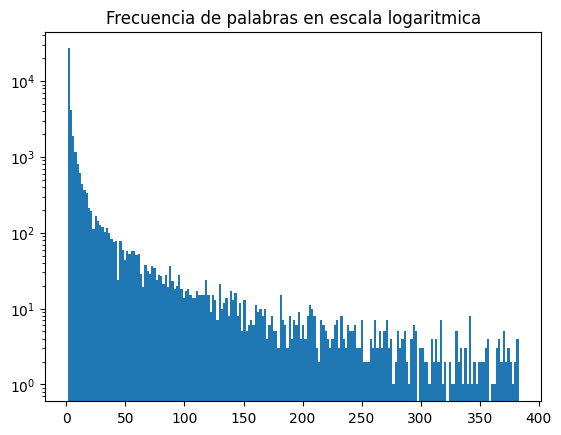

LogisticRegression(C=0.13)

In [ ]:
print('El mejor resultado fue: {}'.format(gridSearch.best_score_))
print('Best parameters:')
best_parameters = gridSearch.best_estimator_.get_params()

best_min_df = best_parameters['vectorizer__min_df']
best_max_df = best_parameters['vectorizer__max_df']

print("Best min df:", best_min_df)
print("Best max df:", best_max_df)

#best_min_df = 2
#best_max_df = 0.15

best_C = gridSearch.best_params_['classifier__C']
print("Best C:", best_C)

###### OBTENGO EL MEJOR MODELO RESULTADO DEL GRID SEARCH #####
#### Crear una matriz de términos-documentos --> Fit input samples
# Con max_df y min_df obtenidos antes
best_count_vectorizer = CountVectorizer(min_df=best_min_df, max_df=best_max_df)
train_data_Vocab = best_count_vectorizer.fit_transform(articulos_filtrados_train)

# Obtener los unigrams --> Frecuencia de palabras en todos los documentos en train
doc_freq = np.array(train_data_Vocab.astype(bool).sum(axis=0)).flatten()

a = plt.hist(doc_freq, bins=200,log=True)
plt.title('Frecuencia de palabras en escala logaritmica')
plt.show()

##### ENTRENO #####
best_model_pipeline = LogisticRegression(C = best_C)
best_model_pipeline.fit(train_data_Vocab.toarray(), twenty_train["target"])
####################

In [ ]:
porc=sum(np.array(best_model_pipeline.predict(train_data_Vocab.toarray()))==np.array(twenty_train["target"]))/cantArticulosTrain*100
print("TRAIN\nEl porcentaje de artículos clasificados correctamente es: {}%".format(porc))

TRAIN
El porcentaje de artículos clasificados correctamente es: 91.97878687437853%


### Validation

In [ ]:
cantArticulosValidation = len(twenty_validation["data"]) #Cantidad de artículos periodísticos
print("VALIDATION\nCantidad de articulos:", cantArticulosValidation )
validation_data_Vocab = best_count_vectorizer.transform(articulos_filtrados_validation)

porc=sum(np.array(best_model_pipeline.predict(validation_data_Vocab.toarray()))==np.array(twenty_validation["target"]))/cantArticulosValidation*100
print("El porcentaje de artículos clasificados correctamente es: {}%".format(porc))

VALIDATION
Cantidad de articulos: 2263
El porcentaje de artículos clasificados correctamente es: 69.06760936809545%


## Test

In [ ]:
cantArticulosTest = len(twenty_test.data) #Cantidad de artículos periodísticos
print("TEST\nCantidad de articulos:", cantArticulosTest )
test_data_Vocab = best_count_vectorizer.transform(articulos_filtrados_test)

porc=sum(np.array(best_model_pipeline.predict(test_data_Vocab.toarray()))==np.array(twenty_test["target"]))/cantArticulosTest*100
print("El porcentaje de artículos clasificados correctamente es: {}%".format(porc))

TEST
Cantidad de articulos: 7532
El porcentaje de artículos clasificados correctamente es: 62.519915029208704%


# Multinomial Naive Bayes con TF IDF

## Train

### Busqueda de Hiperparametros: max_df, min_df y alpha

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

#### Count Vectorizer  ---> Max df y Min df
#max_df: Límite en la frecuencia máxima de documento de las palabras.
#        Se eliminan las palabras que aparezcan en más del max_df% de los documentos.
#min_df: Límite en la frecuencia mínima de documento de las palabras.
#        Se eliminan las palabras que aparezcan en menos del min_df% de los documentos.

#### MultinomialNB   ---> alpha
# alpha: suavizado de la sprobabilidades
TfidfVctr = TfidfVectorizer()
MNBmodel = MultinomialNB()

param_grid = {
                #'vectorizer__max_df' : [0.15],
                'vectorizer__max_df' : np.linspace(0.3, 0.4, num=5),
                #'vectorizer__min_df' : [1,2,3],
                'vectorizer__min_df' : [1],
                #'classifier__alpha': [ 0.005 , 0.000015]
                'classifier__alpha' : np.linspace(0.02, 0.03, num=5)
              }

pipeline = Pipeline([
    ('vectorizer', TfidfVctr),
    ('classifier', MNBmodel)
])

gridSearch = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=10, refit = True)
gridSearch.fit(articulos_filtrados_train, twenty_train["target"])  # Fit the training data

Fitting 3 folds for each of 25 candidates, totalling 75 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'classifier__alpha': array([0.02  , 0.0225, 0.025 , 0.0275, 0.03  ]),
                         'vectorizer__max_df': array([0.3  , 0.325, 0.35 , 0.375, 0.4  ]),
                         'vectorizer__min_df': [1]},
             scoring='accuracy', verbose=10)

El mejor resultado fue: 0.7317423489117224
Best parameters:
Best min df: 1
Best max df: 0.375
Best alpha: 0.025


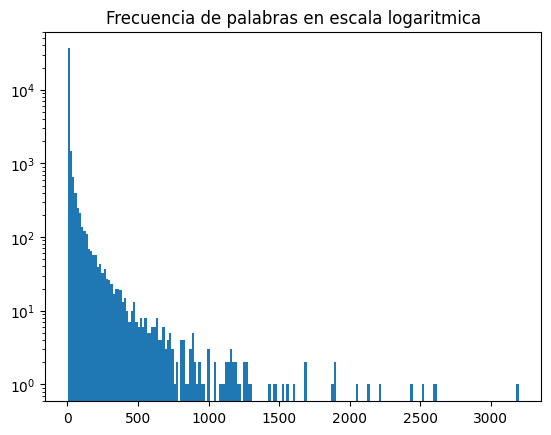

MultinomialNB(alpha=0.025)

In [ ]:
print('El mejor resultado fue: {}'.format(gridSearch.best_score_))
print('Best parameters:')
best_parameters = gridSearch.best_estimator_.get_params()

best_min_df = best_parameters['vectorizer__min_df']
best_max_df = best_parameters['vectorizer__max_df']

print("Best min df:", best_min_df)
print("Best max df:", best_max_df)

#best_min_df = 1
#best_max_df = 0.4

best_alpha = gridSearch.best_params_['classifier__alpha']
print("Best alpha:", best_alpha)

###### OBTENGO EL MEJOR MODELO RESULTADO DEL GRID SEARCH #####
#### Crear una matriz de términos-documentos --> Fit input samples
# Con max_df y min_df obtenidos antes
best_count_vectorizer = TfidfVectorizer(min_df=best_min_df, max_df=best_max_df)
train_data_Vocab = best_count_vectorizer.fit_transform(articulos_filtrados_train)

# Obtener los unigrams --> Frecuencia de palabras en todos los documentos en train
doc_freq = np.array(train_data_Vocab.astype(bool).sum(axis=0)).flatten()

a = plt.hist(doc_freq, bins=200,log=True)
plt.title('Frecuencia de palabras en escala logaritmica')
plt.show()

##### ENTRENO #####
best_model_pipeline = MultinomialNB(alpha = best_alpha)
best_model_pipeline.fit(train_data_Vocab.toarray(), twenty_train["target"])
####################


In [ ]:
porc=sum(np.array(best_model_pipeline.predict(train_data_Vocab.toarray()))==np.array(twenty_train["target"]))/cantArticulosTrain*100
print("TRAIN\nEl porcentaje de artículos clasificados correctamente es: {}%".format(porc))

TRAIN
El porcentaje de artículos clasificados correctamente es: 94.49784554192907%


### Validation

In [ ]:
cantArticulosValidation = len(twenty_validation["data"]) #Cantidad de artículos periodísticos
print("VALIDATION\nCantidad de articulos:", cantArticulosValidation )
validation_data_Vocab = best_count_vectorizer.transform(articulos_filtrados_validation)

porc=sum(np.array(best_model_pipeline.predict(validation_data_Vocab.toarray()))==np.array(twenty_validation["target"]))/cantArticulosValidation*100
print("El porcentaje de artículos clasificados correctamente es: {}%".format(porc))

VALIDATION
Cantidad de articulos: 2263
El porcentaje de artículos clasificados correctamente es: 76.18205921343349%


## Test

In [ ]:
cantArticulosTest = len(twenty_test.data) #Cantidad de artículos periodísticos
print("TEST\nCantidad de articulos:", cantArticulosTest )
test_data_Vocab = best_count_vectorizer.transform(articulos_filtrados_test)

porc=sum(np.array(best_model_pipeline.predict(test_data_Vocab.toarray()))==np.array(twenty_test["target"]))/cantArticulosTest*100
print("El porcentaje de artículos clasificados correctamente es: {}%".format(porc))

TEST
Cantidad de articulos: 7532
El porcentaje de artículos clasificados correctamente es: 68.75995751460435%


# Logistic Regression con TF IDF



## Train

### Busqueda de Hiperparametros: max_df, min_df y C

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

#### Count Vectorizer  ---> Max df y Min df
#max_df: Límite en la frecuencia máxima de documento de las palabras.
#        Se eliminan las palabras que aparezcan en más del max_df% de los documentos.
#min_df: Límite en la frecuencia mínima de documento de las palabras.
#        Se eliminan las palabras que aparezcan en menos del min_df% de los documentos.

#### Logistic Regression --> C
# La fuerza de regularizacion del modelo, cuanto castiga a los valores de los coeficientes

TfidfVctr = TfidfVectorizer()
Logismodel = LogisticRegression()

param_grid = {
                #'vectorizer__max_df' : [0.15],
                'vectorizer__max_df' : np.linspace(0.05, 0.3, num=5),
                #'vectorizer__min_df' : [1,2,3],
                'vectorizer__min_df' : [1],
                'classifier__C' : np.linspace(3, 6, num=3)
              }

pipeline = Pipeline([
    ('vectorizer', TfidfVctr),
    ('classifier', Logismodel)
])

gridSearch = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=10, refit = True)
gridSearch.fit(articulos_filtrados_train, twenty_train["target"])  # Fit the training data

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__C': array([3. , 4.5, 6. ]),
                         'vectorizer__max_df': array([0.05  , 0.1125, 0.175 , 0.2375, 0.3   ]),
                         'vectorizer__min_df': [1]},
             scoring='accuracy', verbose=10)

El mejor resultado fue: 0.7149486244613854
Best parameters:
Best min df: 1
Best max df: 0.1125
Best C: 4.5


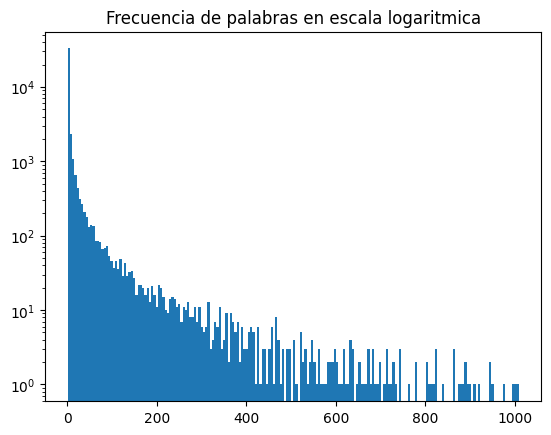

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=4.5)

In [ ]:
print('El mejor resultado fue: {}'.format(gridSearch.best_score_))
print('Best parameters:')
best_parameters = gridSearch.best_estimator_.get_params()

best_min_df = best_parameters['vectorizer__min_df']
best_max_df = best_parameters['vectorizer__max_df']

print("Best min df:", best_min_df)
print("Best max df:", best_max_df)

#best_min_df = 1
#best_max_df = 0.4

best_C = gridSearch.best_params_['classifier__C']
print("Best C:", best_C)

###### OBTENGO EL MEJOR MODELO RESULTADO DEL GRID SEARCH #####
#### Crear una matriz de términos-documentos --> Fit input samples
# Con max_df y min_df obtenidos antes
best_count_vectorizer = TfidfVectorizer(min_df=best_min_df, max_df=best_max_df)
train_data_Vocab = best_count_vectorizer.fit_transform(articulos_filtrados_train)

# Obtener los unigrams --> Frecuencia de palabras en todos los documentos en train
doc_freq = np.array(train_data_Vocab.astype(bool).sum(axis=0)).flatten()

a = plt.hist(doc_freq, bins=200,log=True)
plt.title('Frecuencia de palabras en escala logaritmica')
plt.show()

##### ENTRENO #####
best_model_pipeline = LogisticRegression(C = best_C)
best_model_pipeline.fit(train_data_Vocab.toarray(), twenty_train["target"])
####################


In [ ]:
porc=sum(np.array(best_model_pipeline.predict(train_data_Vocab.toarray()))==np.array(twenty_train["target"]))/cantArticulosTrain*100
print("TRAIN\nEl porcentaje de artículos clasificados correctamente es: {}%".format(porc))

TRAIN
El porcentaje de artículos clasificados correctamente es: 96.35399403380842%


### Validation

In [ ]:
cantArticulosValidation = len(twenty_validation["data"]) #Cantidad de artículos periodísticos
print("VALIDATION\nCantidad de articulos:", cantArticulosValidation )
validation_data_Vocab = best_count_vectorizer.transform(articulos_filtrados_validation)

porc=sum(np.array(best_model_pipeline.predict(validation_data_Vocab.toarray()))==np.array(twenty_validation["target"]))/cantArticulosValidation*100
print("El porcentaje de artículos clasificados correctamente es: {}%".format(porc))

VALIDATION
Cantidad de articulos: 2263
El porcentaje de artículos clasificados correctamente es: 74.28192664604506%


## Test

In [ ]:
cantArticulosTest = len(twenty_test.data) #Cantidad de artículos periodísticos
print("TEST\nCantidad de articulos:", cantArticulosTest )
test_data_Vocab = best_count_vectorizer.transform(articulos_filtrados_test)

porc=sum(np.array(best_model_pipeline.predict(test_data_Vocab.toarray()))==np.array(twenty_test["target"]))/cantArticulosTest*100
print("El porcentaje de artículos clasificados correctamente es: {}%".format(porc))

TEST
Cantidad de articulos: 7532
El porcentaje de artículos clasificados correctamente es: 66.91449814126395%


# Resumen de resultados

**Train**

*   88.27753839354767% para CV con NB

*   91.97878687437853% para CV con LR

*   94.49784554192907% para TF_IDF con NB

*   96.35399403380842% para TF_IDF con LR

**Validation:**

*  72.20503756076006% para CV con NB

*  69.06760936809545% para CV con LR

*  76.18205921343349% para TF_IDF con NB

*  74.28192664604506% para TF_IDF con LR



**Test:**

*  65.2283590015932% para CV con NB

*  62.519915029208704% para CV con LR

*  **68.75995751460435% para TF_IDF con NB**

*  66.91449814126395% para TF_IDF con LR

## Mejor modelo: 68.75996%
Multinomial Naive Bayes con TF_IDF
- Best min df: 1
- Best max df: 0.375
- Best alpha: 0.025
